In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from scipy.io import loadmat, savemat

In [4]:
# Read the Excel file
file_name = 'Data_4_Import_REST.xlsx'  # Replace with your file path
excel_sheet_name = 'Depression Rest'
file_path = os.path.join("Depression_Study", "depression_data", file_name)
df_raw = pd.read_excel(file_path, sheet_name=excel_sheet_name)

# Extract values from the first column into two arrays
healthy_sample = df_raw[df_raw.iloc[:, 1] == 99].iloc[:, 0].tolist()
depressed_sample = df_raw[df_raw.iloc[:, 1] != 99].iloc[:, 0].tolist()

# Print the results
print("Healthy sample:", healthy_sample)
print("Depressed sample:", depressed_sample)
print()
print(df_raw)

Healthy sample: [507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 560, 562, 563, 564, 566, 568, 569, 570, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 588, 589, 590, 593, 596, 599, 600, 601, 603, 609, 611, 612, 615, 617, 619, 620, 621, 623]
Depressed sample: [558, 559, 561, 565, 567, 571, 572, 586, 587, 591, 592, 594, 595, 597, 598, 602, 604, 605, 606, 607, 608, 610, 613, 614, 616, 618, 622, 624, 625, 626, 627, 628]

      id  MDD                         MDD_note  HamD  sex   age   BDI  \
0    507   99                              NaN   NaN  1.0  19.0   0.0   
1    508   99                              NaN   NaN  1.0  18.0   4.0   
2    509   99                              NaN   NaN  1.0  18.0   7.0   
3    510   99                              NaN   NaN  1.0  19

In [ ]:
# Load CSER values from MAT file
cser_open_mat = loadmat("entropy_open.mat")
cser_closed_mat = loadmat("entropy_closed.mat")
cser_band_open_mat = loadmat("entropy_band_open.mat")
cser_band_closed_mat = loadmat("entropy_band_closed.mat")
cser_source_open_mat = loadmat("entropy_source_open.mat")
cser_source_closed_mat = loadmat("entropy_source_closed.mat")
cser_source_band_open_mat = loadmat("entropy_source_band_open.mat")
cser_source_band_closed_mat = loadmat("entropy_source_band_closed.mat")

# Extract field names from cser_open and cser_closed
field_names_open = [int(name[1:]) for name in cser_open_mat['entropy_open'].dtype.names]
field_names_closed = [int(name[1:]) for name in cser_closed_mat['entropy_closed'].dtype.names]

# Extract values from the CSER data
cser_open = np.array([value[0][0] for sublist in cser_open_mat['entropy_open'][0] for value in sublist])
cser_closed = np.array([value[0][0] for sublist in cser_closed_mat['entropy_closed'][0] for value in sublist])

# Extract band values into separate list for each band
cser_band_open = [np.array([value[0][i] for sublist in cser_band_open_mat['entropy_band_open'][0] for value in sublist]) for i in range(5)]
cser_band_closed = [np.array([value[0][i] for sublist in cser_band_closed_mat['entropy_band_closed'][0] for value in sublist]) for i in range(5)]

# Extract CSER from the for each of the 60 sources
cser_source_open = [np.array([value[0][i] for sublist in cser_source_open_mat['entropy_source_open'][0] for value in sublist]) for i in range(60)]
cser_source_closed = [np.array([value[0][i] for sublist in cser_source_closed_mat['entropy_source_closed'][0] for value in sublist]) for i in range(60)]

# Extract CSER from the for each of the 60 sources
cser_source_band_open = np.array([[np.array([value[j][i] for sublist in cser_source_band_open_mat['entropy_source_band_open'][0] for value in sublist]) for i in range(60)] for j in range(5)])
cser_source_band_closed = np.array([[np.array([value[j][i] for sublist in cser_source_band_closed_mat['entropy_source_band_closed'][0] for value in sublist]) for i in range(60)] for j in range(5)])
# i source x j band

print("CSER Open:", cser_open)
print("CSER Closed:", cser_closed)

# print("Field names (open):", field_names_open)
# print("Field names (closed):", field_names_closed)

[-0.02696571 -0.01609135 -0.02500034 -0.02783539 -0.03013244 -0.02707731
 -0.023625   -0.02707899 -0.02709251 -0.02684432 -0.0253881  -0.03227647
 -0.03056102 -0.0311661  -0.0214454  -0.02687924 -0.02597446 -0.01959871
 -0.01733498 -0.02751424 -0.02394668 -0.0358957  -0.02779202 -0.02362073
 -0.0259159  -0.02086353 -0.03051958 -0.02691547  0.10037115 -0.02288153
 -0.02632366 -0.04250584 -0.03103832 -0.03082982 -0.0277103  -0.02665184
 -0.0231517  -0.02894647 -0.02830384 -0.01963828 -0.0195204  -0.03080567
 -0.02942977 -0.02803289 -0.04410272 -0.02714424 -0.01109235 -0.01746027
 -0.02472015 -0.03002213 -0.03115382 -0.03007182 -0.02142973 -0.03283253
 -0.02381696 -0.03316114 -0.0311871  -0.01511185 -0.02138545 -0.03017133
 -0.02250685 -0.02774807 -0.03790117 -0.03802244 -0.03384678 -0.02340117
 -0.02239321 -0.03361503 -0.02194674 -0.01638727 -0.03019829 -0.02397109
 -0.02815916 -0.02137314 -0.03947347 -0.02475344 -0.03994516 -0.02520541
 -0.02868647 -0.03961663 -0.02546588 -0.00621729 -0

In [ ]:
# print(df_raw.columns.tolist())
df = df_raw.copy()
df = df.drop(columns=['MDD_note', 'HamD'])
# print(df.columns.tolist())

missing_ids_open = set(df['id']) - set(field_names_open)
df = df[~df['id'].isin(missing_ids_open)]

df['eyes'] = 'open'
df['source'] = np.nan
df['band'] = np.nan
df['CSER'] = np.nan

print(df.columns.tolist())
print()

# Add CSER values for open eyes
for i, row in df.iterrows():
    id_value = row['id']
    if id_value in field_names_open:
        df.at[i, 'CSER'] = cser_open[field_names_open.index(id_value)]
    else:
        df.at[i, 'CSER'] = np.nan

# For each row in df, duplicate the row with eyes set to 'closed'
df_closed = df.copy()
df_closed['eyes'] = 'closed'
# Add CSER values for closed eyes
for i, row in df_closed.iterrows():
    id_value = row['id']
    if id_value in field_names_closed:
        df_closed.at[i, 'CSER'] = cser_closed[field_names_closed.index(id_value)]
    else:
        df_closed.at[i, 'CSER'] = np.nan

# Combine the two DataFrames
df = pd.concat([df, df_closed], ignore_index=True)
df = df.sort_values(by=['id', 'eyes']).reset_index(drop=True)

print(df)

['id', 'MDD', 'sex', 'age', 'BDI', 'BDI_Anh', 'BDI_Mel', 'TAI', 'eyes', 'source', 'band', 'CSER']

      id  MDD  sex   age   BDI  BDI_Anh  BDI_Mel   TAI    eyes  source  band  \
0    507   99  1.0  19.0   0.0      0.0      0.0  23.0  closed     NaN   NaN   
1    507   99  1.0  19.0   0.0      0.0      0.0  23.0    open     NaN   NaN   
2    508   99  1.0  18.0   4.0      0.0      2.0  47.0  closed     NaN   NaN   
3    508   99  1.0  18.0   4.0      0.0      2.0  47.0    open     NaN   NaN   
4    509   99  1.0  18.0   7.0      0.0      3.0  44.0  closed     NaN   NaN   
..   ...  ...  ...   ...   ...      ...      ...   ...     ...     ...   ...   
233  626    1  1.0  18.0  14.0      3.0      4.0  41.0    open     NaN   NaN   
234  627    2  2.0  19.0  30.0      4.0      9.0  47.0  closed     NaN   NaN   
235  627    2  2.0  19.0  30.0      4.0      9.0  47.0    open     NaN   NaN   
236  628    1  2.0  18.0  19.0      3.0      5.0  56.0  closed     NaN   NaN   
237  628    1  2.0  1

In [ ]:
df_cols = df_raw.copy()

# Add average overall CSER columns
df_cols['cser_open'] = pd.Series(cser_open, index=df_cols[df_cols['id'].isin(field_names_open)].index)
df_cols['cser_closed'] = pd.Series(cser_closed, index=df_cols[df_cols['id'].isin(field_names_closed)].index)
# df_cols['cser_diff'] = df_cols['cser_open'] - df_cols['cser_closed']

# Add average per band CSER columns
band_names = ["1_4","4_8","8_12","12_30","30_100"]
for i, band in enumerate(band_names):
    df_cols[f'cser_band_{i+1}_open'] = pd.Series(bands_open_values[i], index=df_cols[df_cols['id'].isin(field_names_open)].index)
    df_cols[f'cser_band_{i+1}_closed'] = pd.Series(bands_closed_values[i], index=df_cols[df_cols['id'].isin(field_names_closed)].index)

# Add CSER per source columns
for i in range(60):
    df_cols[f'source_{i+1}_open'] = pd.Series(sources_open_values[i], index=df_cols[df_cols['id'].isin(field_names_open)].index)
    df_cols[f'source_{i+1}_closed'] = pd.Series(sources_closed_values[i], index=df_cols[df_cols['id'].isin(field_names_closed)].index)

# Add CSER per source per band columns
for j in range(5):
    for i in range(60):
        df_cols[f'source_{i+1}_band_{j+1}_open'] = pd.Series(sources_bands_open[j][i], index=df_cols[df_cols['id'].isin(field_names_open)].index)
        df_cols[f'source_{i+1}_band_{j+1}_closed'] = pd.Series(sources_bands_closed[j][i], index=df_cols[df_cols['id'].isin(field_names_closed)].index)

# Add CSER per source across bands 1,2,3
for i in range(60):
    df_cols[f'source_{i+1}_open_bands_1_2_3'] = pd.Series(np.sum(sources_bands_open[0:3, i], axis=0), index=df_cols[df_cols['id'].isin(field_names_open)].index)
    df_cols[f'source_{i+1}_closed_bands_1_2_3'] = pd.Series(np.sum(sources_bands_closed[0:3, i], axis=0), index=df_cols[df_cols['id'].isin(field_names_closed)].index)

df_cols['depressed'] = df_cols.iloc[:, 1].apply(lambda x: 1 if x != 99 else 0)

C:\Users\lukad\AppData\Local\Temp\ipykernel_7228\2573290252.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'source_{i+1}_closed'] = pd.Series(sources_closed_values[i], index=df[df['id'].isin(field_names_closed)].index)
C:\Users\lukad\AppData\Local\Temp\ipykernel_7228\2573290252.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'source_{i+1}_open'] = pd.Series(sources_open_values[i], index=df[df['id'].isin(field_names_open)].index)
C:\Users\lukad\AppData\Local\Temp\ipykernel_7228\2573290252.py:17: PerformanceWarn

In [23]:
tst = df[df['id'].isin(field_names_open)]
print(tst)

      id  MDD                         MDD_note  HamD  sex   age   BDI  \
0    507   99                              NaN   NaN  1.0  19.0   0.0   
1    508   99                              NaN   NaN  1.0  18.0   4.0   
2    509   99                              NaN   NaN  1.0  18.0   7.0   
3    510   99                              NaN   NaN  1.0  19.0   1.0   
4    511   99                              NaN   NaN  2.0  22.0   1.0   
..   ...  ...                              ...   ...  ...   ...   ...   
117  624    1                              NaN  21.0  1.0  20.0  23.0   
118  625    2             subsyndromal current   4.0  1.0  19.0  16.0   
119  626    1                              NaN  10.0  1.0  18.0  14.0   
120  627    2                              NaN   3.0  2.0  19.0  30.0   
121  628    1  dysthymic, Hx Alc curr cannabis  15.0  2.0  18.0  19.0   

     BDI_Anh  BDI_Mel   TAI  ...  source_56_closed_bands_1_2_3  \
0        0.0      0.0  23.0  ...                     -0.1

In [8]:
cser_open_bands_123 = np.mean(np.sum(sources_bands_open[:3], axis=0), axis=0)
cser_closed_bands_123 = np.mean(np.sum(sources_bands_closed[:3], axis=0), axis=0)
depressed = df['depressed'].values

# df1 = pd.DataFrame({
#     'cser_open_bands_123': cser_open_bands_123,
#     'cser_closed_bands_123': cser_closed_bands_123,
#     'depressed': depressed
# })

In [26]:
# print(np.shape(sources_bands_open))

print(df)
print(df.columns.tolist())

# print id column & field names
# print("ID column:\t\t", df['id'].tolist())
# print("Field names (open):\t", field_names_open)
# print("Field names (closed):\t", field_names_closed)

# print ids which are not in the field names
missing_ids_open = set(df['id']) - set(field_names_open)
# print("Missing IDs (open):\t", missing_ids_open)

# print rows where 'id' is not in field names
missing_rows_open = df[~df['id'].isin(field_names_open)]
# print("Missing rows (open):\n", missing_rows_open) 

example_row = df[df['id'] == 628]
# print("Example row for ID 628:\n", example_row)

      id  MDD                         MDD_note  HamD  sex   age   BDI  \
0    507   99                              NaN   NaN  1.0  19.0   0.0   
1    508   99                              NaN   NaN  1.0  18.0   4.0   
2    509   99                              NaN   NaN  1.0  18.0   7.0   
3    510   99                              NaN   NaN  1.0  19.0   1.0   
4    511   99                              NaN   NaN  2.0  22.0   1.0   
..   ...  ...                              ...   ...  ...   ...   ...   
117  624    1                              NaN  21.0  1.0  20.0  23.0   
118  625    2             subsyndromal current   4.0  1.0  19.0  16.0   
119  626    1                              NaN  10.0  1.0  18.0  14.0   
120  627    2                              NaN   3.0  2.0  19.0  30.0   
121  628    1  dysthymic, Hx Alc curr cannabis  15.0  2.0  18.0  19.0   

     BDI_Anh  BDI_Mel   TAI  ...  source_56_closed_bands_1_2_3  \
0        0.0      0.0  23.0  ...                     -0.1

In [ ]:
# List outliers beyond 75th percentile and below 25th percentile - using IQR method
outliers_open = df[(df['cser_open'] > df['cser_open'].quantile(0.75) + 1.5 * (df['cser_open'].quantile(0.75) - df['cser_open'].quantile(0.25))) | 
                   (df['cser_open'] < df['cser_open'].quantile(0.25) - 1.5 * (df['cser_open'].quantile(0.75) - df['cser_open'].quantile(0.25)))]
outliers_closed = df[(df['cser_closed'] > df['cser_closed'].quantile(0.75) + 1.5 * (df['cser_closed'].quantile(0.75) - df['cser_closed'].quantile(0.25))) |
                   (df['cser_closed'] < df['cser_closed'].quantile(0.25) - 1.5 * (df['cser_closed'].quantile(0.75) - df['cser_closed'].quantile(0.25)))]
print("Outliers in CSER Open:\n\n", outliers_open[['id', 'cser_open']])
print("\nOutliers in CSER Closed:\n\n", outliers_closed[['id', 'cser_closed']])

# Identify the median values for cser_open and cser_closed
median_cser_open_id = df[df['cser_open'] == df['cser_open'].median()]['id'].values[0]
median_cser_closed_id = df[df['cser_closed'] == df['cser_closed'].median()]['id'].values[0]
print("\nID of the entry with median cser_open value:", median_cser_open_id)
print("ID of the entry with median cser_closed value:", median_cser_closed_id)

# Drop outliers from the DataFrame if they exist
outlier_ids = ['527','535']
ids_in_df = df['id'].astype(str).isin(outlier_ids)
if ids_in_df.any():
    df = df[~ids_in_df]
print("\nDropped outliers with IDs:", outlier_ids)

Outliers in CSER Open:

      id  cser_open
26  533  -3.344447
28  535   1.891393
84  591  -1.878819

Outliers in CSER Closed:

      id  cser_closed
26  533    -3.353643
47  554    -2.168108
55  562    -2.073983
84  591    -1.986633

ID of the entry with median cser_open value: 532
ID of the entry with median cser_closed value: 586

Dropped outliers with IDs: ['527', '535']


In [ ]:
def permutation_test(data1, data2, num_permutations=10000):
    """Perform a permutation test to compare two independent samples."""
    observed_diff = np.mean(data1) - np.mean(data2)
    combined = np.concatenate([data1, data2])
    count = 0

    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_data1 = combined[:len(data1)]
        new_data2 = combined[len(data1):]
        new_diff = np.mean(new_data1) - np.mean(new_data2)
        if abs(new_diff) >= abs(observed_diff):
            count += 1

    p_value = count / num_permutations
    return observed_diff, p_value


Permutation test results for CSER Open:
Observed difference: 0.004525434493115481 P-value: 0.2541

Permutation test results for CSER Closed:
Observed difference: 0.0023330890127380884 P-value: 0.3362

T-test results for CSER Open:
T-statistic: 1.4917640760568032 P-value: 0.13950972499708755

T-test results for CSER Closed:
T-statistic: 1.0163639174174772 P-value: 0.31396370291928044


<Axes: xlabel='depressed', ylabel='cser_band_3_open'>

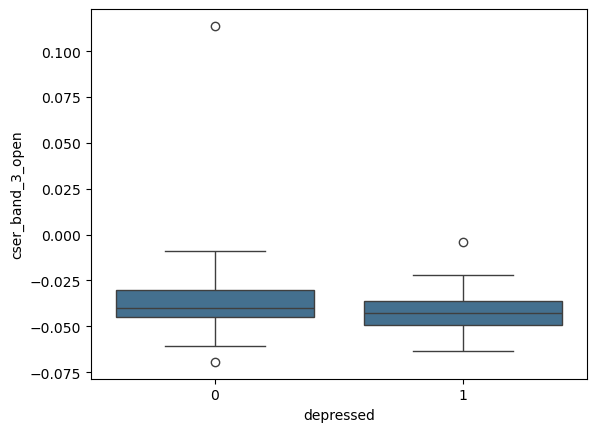

In [ ]:
from scipy.stats import ttest_ind
# Perform t-tests for CSER values
i = 3
open_condition = f'cser_band_{i}_open'
closed_condition = f'cser_band_{i}_closed'

t_stat_open, p_value_open = ttest_ind(df[df['depressed'] == 0][open_condition], df[df['depressed'] == 1][open_condition], nan_policy='omit', equal_var=False)
t_stat_closed, p_value_closed = ttest_ind(df[df['depressed'] == 0][closed_condition], df[df['depressed'] == 1][closed_condition], nan_policy='omit', equal_var=False)

stat_open, p_value_open_perm = permutation_test(df[df['depressed'] == 0][open_condition].dropna().values, df[df['depressed'] == 1][open_condition].dropna().values)
stat_closed, p_value_closed_perm = permutation_test(df[df['depressed'] == 0][closed_condition].dropna().values, df[df['depressed'] == 1][closed_condition].dropna().values)

print("\nPermutation test results for CSER Open:")
print("Observed difference:", stat_open, "P-value:", p_value_open_perm)
print("\nPermutation test results for CSER Closed:")
print("Observed difference:", stat_closed, "P-value:", p_value_closed_perm)

print("\nT-test results for CSER Open:")
print("T-statistic:", t_stat_open, "P-value:", p_value_open)
print("\nT-test results for CSER Closed:")
print("T-statistic:", t_stat_closed, "P-value:", p_value_closed)

sns.boxplot(x='depressed', y=open_condition, data=df, saturation=0.5)
# sns.boxplot(x='depressed', y=closed_condition, data=df, saturation=0.5)

In [ ]:
df['intercept'] = 1

target_columns = ['cser_open', 'cser_closed'] + [f'cser_band_{i+1}_open' for i in range(5)] + [f'cser_band_{i+1}_closed' for i in range(5)]
# target_columns += [f'source_{i+1}_open' for i in range(60)] + [f'source_{i+1}_closed' for i in range(60)]
# target_columns += [f'source_{i+1}_band_{j+1}_open' for i in range(60) for j in range(5)] + [f'source_{i+1}_band_{j+1}_closed' for i in range(60) for j in range(5)]

df['squared_age'] = df['age'] ** 2

for target in target_columns:
    model = sm.RLM(df[target], df[['intercept', 'BDI', 'sex', 'age', 'squared_age']], missing='drop', M=sm.robust.norms.HuberT())
    results = model.fit()
    print(results.summary())
    # if results.pvalues['depressed'] <= 0.05:
        # print(f'{target} > {results.pvalues["depressed"]}')


                    Robust linear Model Regression Results                    
Dep. Variable:              cser_open   No. Observations:                  118
Model:                            RLM   Df Residuals:                      113
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 27 May 2025                                         
Time:                        16:13:01                                         
No. Iterations:                    22                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -3.8662      3.524     -1.097      

(array([ 1.,  0.,  3.,  0.,  5.,  1.,  4.,  9., 10., 12., 10., 15.,  7.,
         8., 13.,  4.,  4.,  2.,  1.,  3.,  3.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-3.34444703, -3.29559277, -3.24673851, -3.19788425, -3.14902999,
        -3.10017573, -3.05132147, -3.00246721, -2.95361295, -2.90475869,
        -2.85590443, -2.80705017, -2.75819591, -2.70934165, -2.66048739,
        -2.61163313, -2.56277887, -2.51392461, -2.46507035, -2.41621609,
        -2.36736183, -2.31850757, -2.26965331, -2.22079905, -2.17194478,
        -2.12309052, -2.07423626, -2.025382  , -1.97652774, -1.92767348,
        -1.87881922]),
 <BarContainer object of 30 artists>)

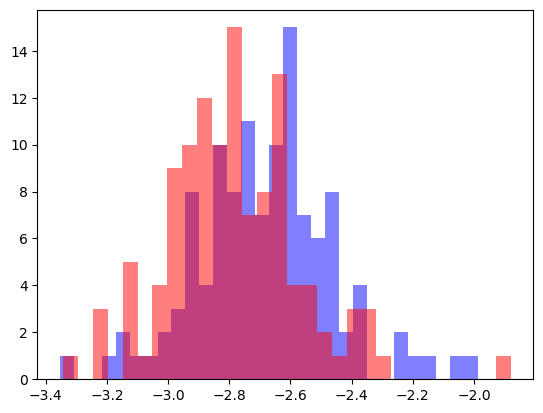

In [ ]:
plt.hist(df['cser_closed'], bins=30, alpha=0.5, color='blue', label='CSER Closed')
plt.hist(df['cser_open'], bins=30, alpha=0.5, color='red', label='CSER Open')